In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scvelo as scv
import scanpy as sc

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset
from symsimDataset import SymsimBifur, SymsimTree, SymsimBranch, SymsimLinear, SymsimCycle

from symsimDatasetTest import SymsimTreeNoisy, SymsimBifurNoisy, SymsimLinearNoisy

from realDataset import forebrainDataset, chromaffinDataset, forebrainDataset_large

from unsupervised_loss import UnsupervisedLoss

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from model.autoencoder import AutoEncoder

from model.mymodel import MyModel, GraphSAGEModel, FCModel, veloModel, DiffusionModel


from math import sqrt
import scprep
import utils
import backbone

from torch_geometric.data import Data

In [2]:
dataBifur = SymsimBifur()
dataTree = SymsimTree()
datalinear = SymsimLinear()
# dataDyngen = RnaVeloDataset()
forebrain = forebrainDataset()
forebrain_large = forebrainDataset_large()
chromaffin = chromaffinDataset()

dataTreeNoisy = SymsimTreeNoisy()

In [3]:
t = np.arange(1,10)

# dataset for validation
val_mask = [10*i+9 for i in range(4)]

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
Path = "./trained_model/Diffusion_pos_only_0.9123.pt"
# Path = "./Diffusion_symsim_tree_bifur_trifur.pt"

model = DiffusionModel(dataBifur.num_features, hidden1 = 128, hidden2 = 64, max_diffusion = 10, include_reversed = True, device = device, dropout1=0.2, dropout2=0.2).to(device)

model.load_state_dict(torch.load(Path, map_location=torch.device('cpu')))
model.eval()

DiffusionModel(
  (conv1): GraphDiffusion (300 -> 128)
  (conv2): GraphDiffusion (128 -> 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
  (relu1): LeakyReLU(negative_slope=0.1)
  (relu2): LeakyReLU(negative_slope=0.1)
)

# Noiseless dataset

pearson corr:0.7245692509799421, kendall tau:0.651837644985793
pearson corr:0.6788236047533114, kendall tau:0.6611708710318607
pearson corr:0.621210691201703, kendall tau:0.6476324931200818
pearson corr:0.7173861255000522, kendall tau:0.6159428943490918


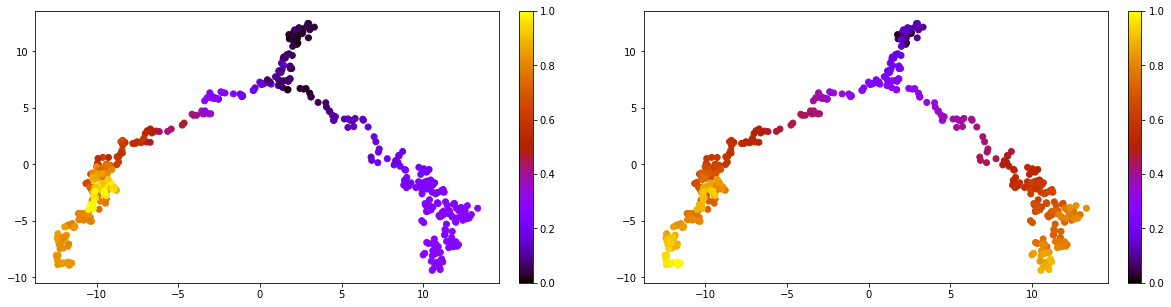

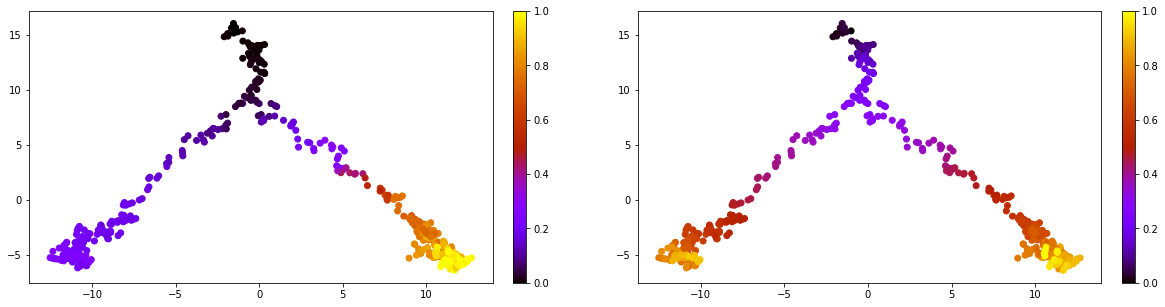

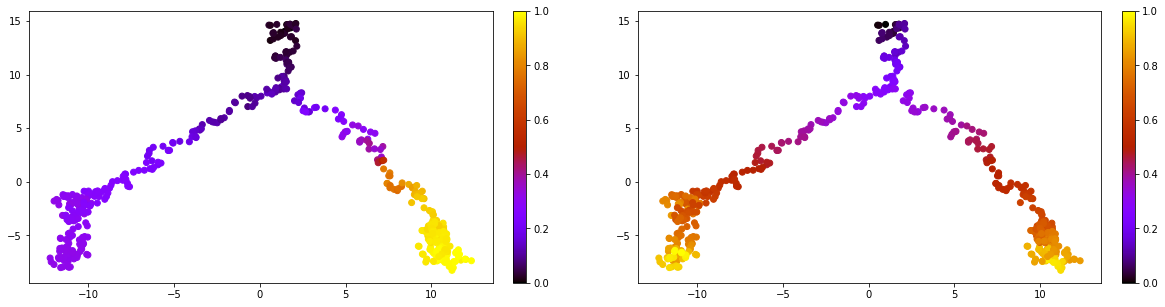

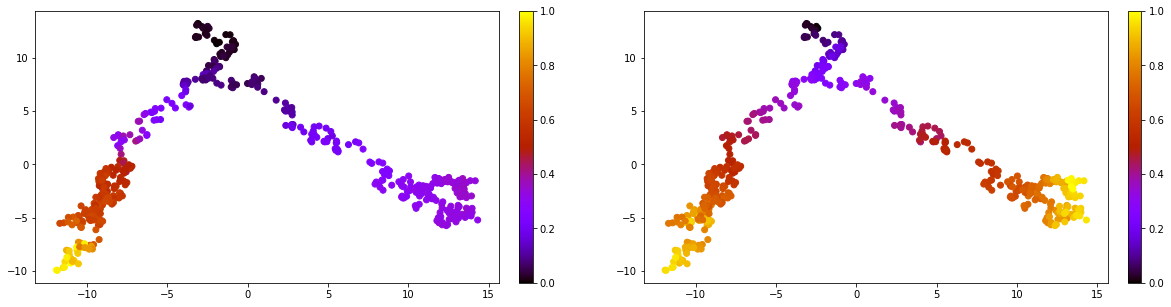

In [16]:
for idx, data in enumerate(DataLoader(dataTree[val_mask])):
    pt = data.y_vdpt[0][0]
    X_pca = utils.pca_op(data.x.detach().numpy())
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

pearson corr:0.55737644, kendall tau:0.44673107287178526
pearson corr:0.7891918, kendall tau:0.5801724562700172
pearson corr:0.9087547, kendall tau:0.7064321412345037
pearson corr:0.899413, kendall tau:0.7086636619284256


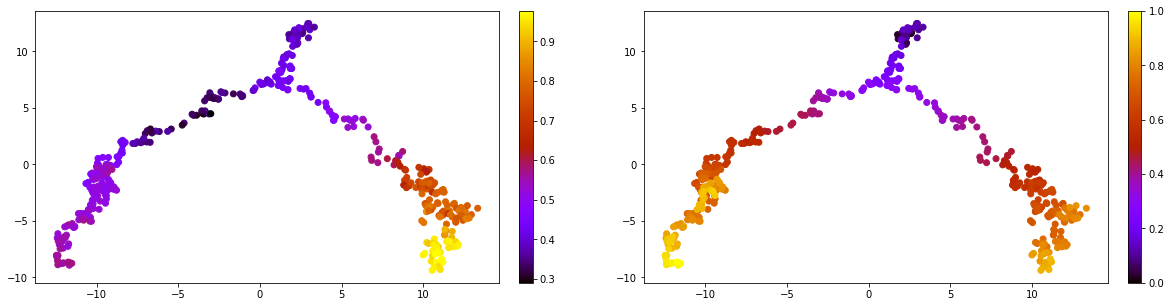

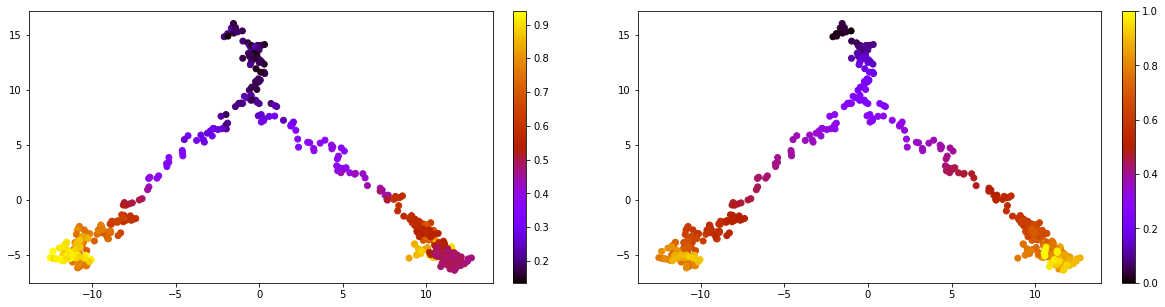

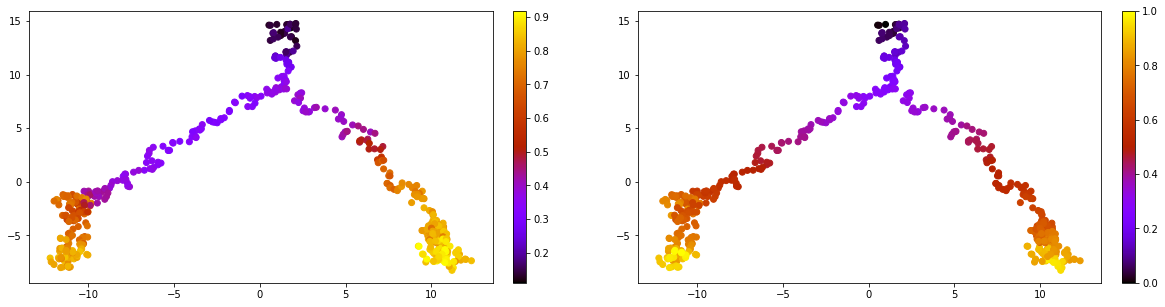

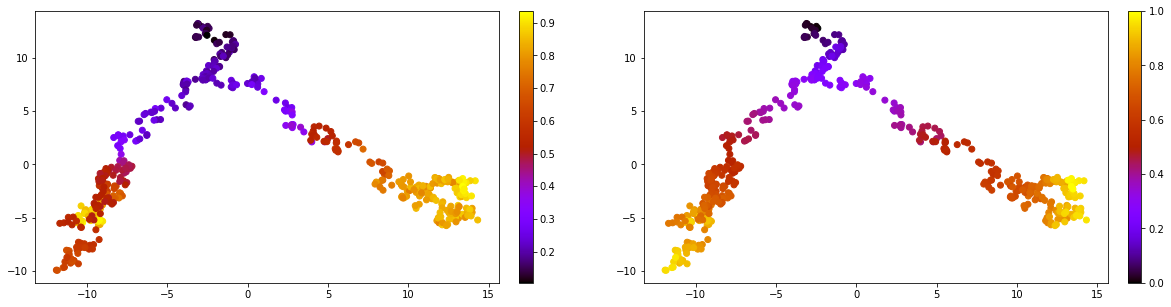

In [17]:
for idx, data in enumerate(DataLoader(dataTree[val_mask])):
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)

    pt, _, _ = model(data.to(device))
    pt = pt.detach().cpu().numpy().reshape(-1)
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

# Noisy dataset

pearson corr:-0.23762445020568854, kendall tau:-0.27401536685132827
pearson corr:-0.02391550640492265, kendall tau:0.027770126455490173
pearson corr:0.700639959329548, kendall tau:0.6125871207378658
pearson corr:0.6742948195492894, kendall tau:0.6145402946454656


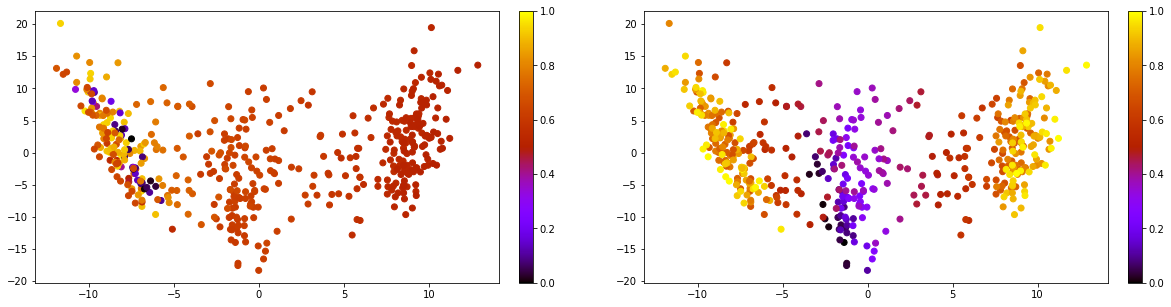

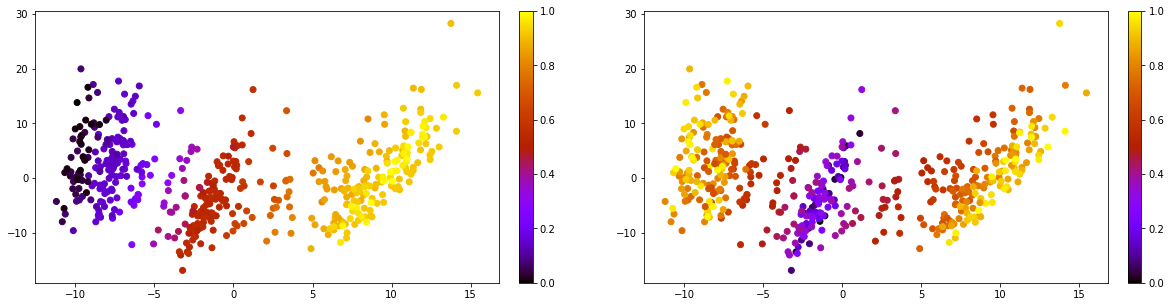

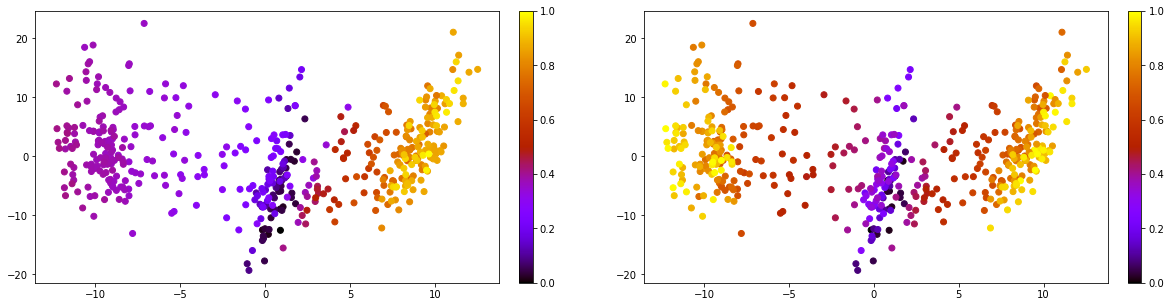

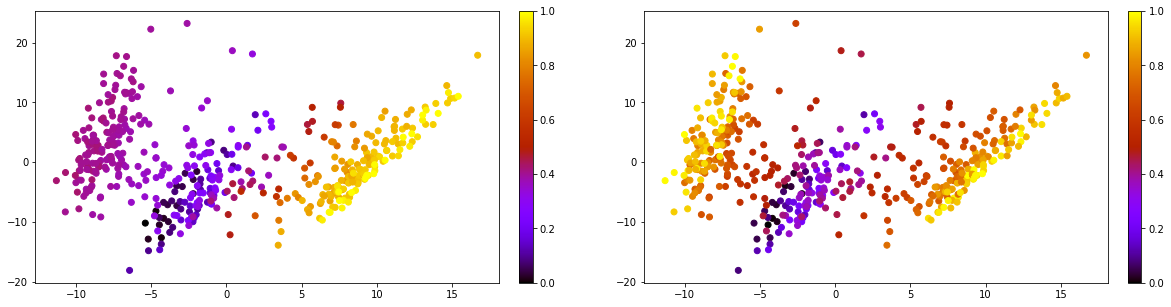

In [18]:
for idx, data in enumerate(DataLoader(dataTreeNoisy[val_mask])):
    pt = data.y_vdpt[0][0]
    X_pca = utils.pca_op(data.x.detach().numpy())
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

pearson corr:0.866323, kendall tau:0.616677100287968
pearson corr:0.79619676, kendall tau:0.5895830724928008
pearson corr:0.7831165, kendall tau:0.5180334710571345
pearson corr:0.9038607, kendall tau:0.6607821042527441


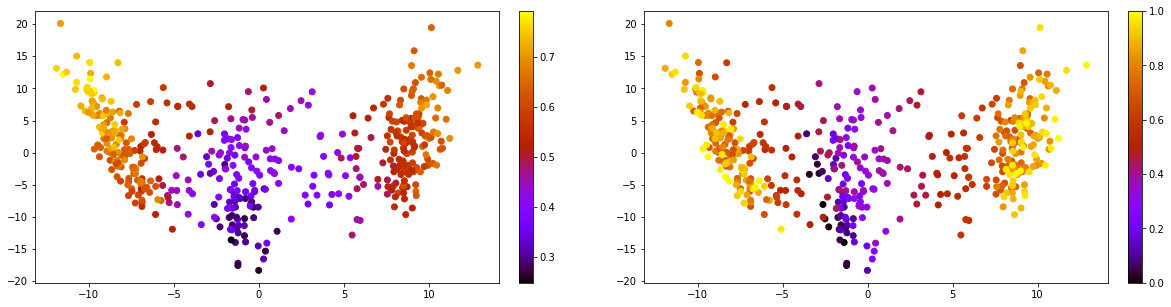

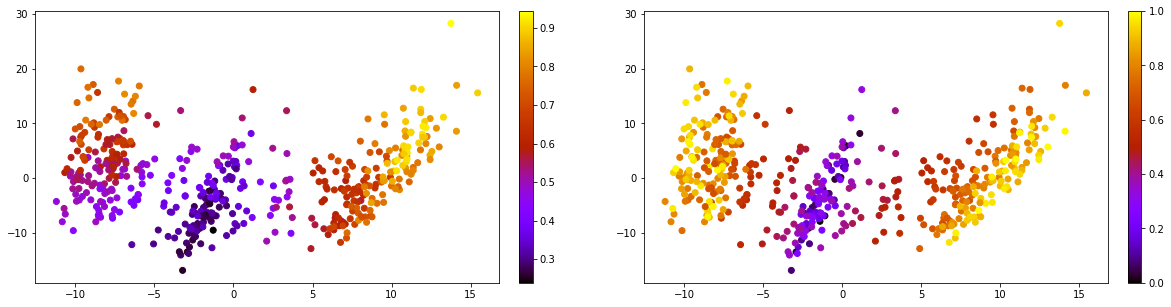

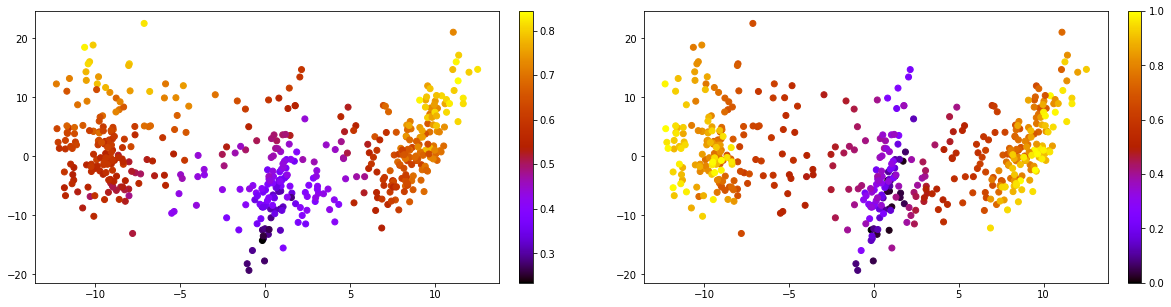

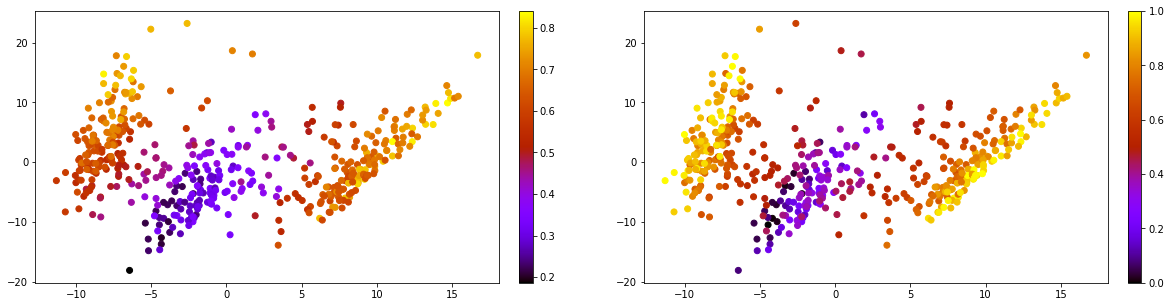

In [19]:
for idx, data in enumerate(DataLoader(dataTreeNoisy[val_mask])):
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)

    pt, _, _ = model(data.to(device))
    pt = pt.detach().cpu().numpy().reshape(-1)
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

# Dyngen dataset

In [5]:
for idx, data in enumerate(DataLoader(dataDyngen)):
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)
    
    pt, _, _ = model(data.to(device))
    pt = pt.detach().cpu().numpy().reshape(-1)
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

NameError: name 'dataDyngen' is not defined

# Real dataset

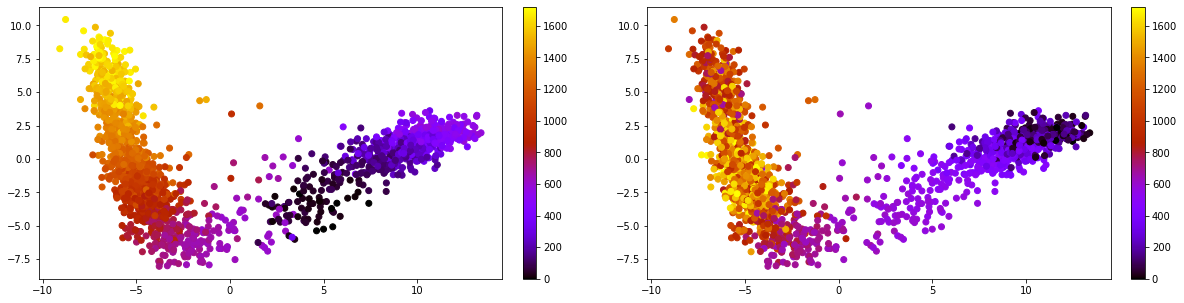

In [22]:
for idx, data in enumerate(DataLoader(forebrain_large)):
    pt = data.y_vdpt[0][0].squeeze()

    # pt = np.argsort(pt)
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)
    fig = plt.figure(figsize = (20, 5))
    ax1,ax2 = fig.subplots(1,2)
    
    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]

    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt, _, _ = model(data.to(device))
    pt = pt.detach().numpy().squeeze()

    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]

    # pt = (pt - np.min(pt))/(np.max(pt)-np.min(pt))
    # print(len(pt))
    # pt = np.argsort(pt)
    
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)    

    

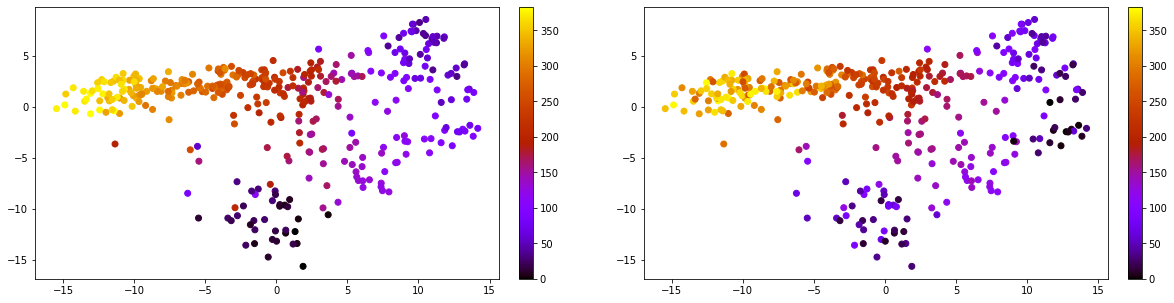

In [23]:
for idx, data in enumerate(DataLoader(chromaffin)):
    pt = data.y_vdpt[0][0].squeeze()

    # pt = np.argsort(pt)
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)
    fig = plt.figure(figsize = (20, 5))
    ax1,ax2 = fig.subplots(1,2)
    
    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]

    pseudo_visual = ax1.scatter(-X_pca[:,0], -X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt, _, _ = model(data.to(device))
    pt = pt.detach().numpy().squeeze()

    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]
    # pt = (pt - np.min(pt))/(np.max(pt)-np.min(pt))
    # print(len(pt))
    # pt = np.argsort(pt)
    
    pseudo_visual = ax2.scatter(-X_pca[:,0], -X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)  

In [5]:
adata = anndata.read_h5ad('./data/real_dataset/chromaffin.h5ad')

scv.pp.filter_and_normalize(adata, flavor = 'cell_ranger', min_shared_counts=20, n_top_genes=301, log=True)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata, mode='stochastic') 
scv.tl.velocity_graph(adata)

Filtered out 9895 genes that are detected in less than 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [6]:
adata

AnnData object with n_obs × n_vars = 384 × 300 
    obs: 'Clusters', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_settings', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spanning', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

computing velocity graph
... 100%    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


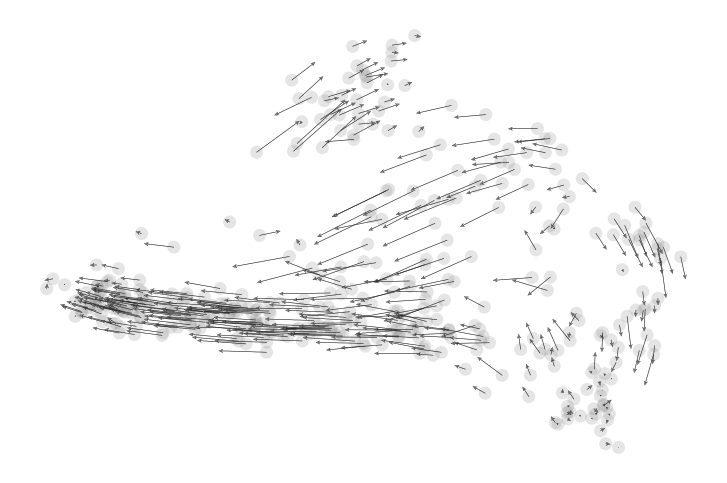

In [68]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding(adata, dpi = 150, basis='pca', arrow_length= 10)